In [1]:
# Experimental work in using CFGs (Tracery) and P-CFGs 
# to generate narratives from Talk of the town simulation by James Ryan
# - Chris & Mayank

In [2]:
import tracery
from tracery.modifiers import base_english

In [3]:
characters = ["Mayank", "Chris", "Rohan", "Tom"]
character_adjectives = ["a happy", "a jolly", "a kind", "an antisocial", "a reclusive"]
morning_activities = ["brushes their teeth", "picks up the newspaper from the front door", "pours themself a cup of coffee", "makes breakfast"]
weathers = ["rainy", "sunny", "cloudy", "warm", "cold", "hot", "freezing"]
news_sources = ["TV", "newspaper", "weather forecast"]
activities = ["said hey", "ignored #mainCharacter#", "greeted #mainCharacter#", "threatened #mainCharacter#", "asked #mainCharacter# out for lunch"]
relationships = ["friends", "foes", "partners", "rivals", "strangers", "colleagues", "siblings"]
occupation_workplace = [("Barber", "Hair Salon"), ("Mechanic", "Garage"), ("Accountant", "Bank"), ("Professor", "College"), ("Chef", "Restaurant")]
rules_us = {
  "origin": ["[mainCharacter:#character#]#intro# #[#setOccupation#]episode# #conclusion#"],
  "character": characters,
  "intro": ["#mainCharacter# wakes up and #morningActivity#. #weatherDescription# #mainCharacterDescription#"],
  "mainCharacterDescription": ["#mainCharacter# is #adjective# person."],
  "adjective" : character_adjectives,
  "morningActivity" : morning_activities,
  "weatherDescription" :["The #newsSource# predicted that it's going to be #weather# today."],
  "weather" : weathers,
  "newsSource" : news_sources,
  "episode": ["#mainCharacter# goes to the #mcWorkplace# because they work as #mcOccupation#. #interaction#. #interaction#."],
  "interaction" : ["[interactionCharacter:#character#]#interactionCharacter# went to the #mcWorkplace#. #interactionCharacter# and #mainCharacter# were #relationship#. #interactionCharacter# #performActivity#"],
  "relationship" : relationships,
  "performActivity": activities,
  "setOccupation" : ["[mcWorkplace:{}][mcOccupation:{}]".format(w, o) for o, w in  occupation_workplace],
  "conclusion" : ["conclusion"],
  "event" : ["event"]
}

In [4]:
grammar = tracery.Grammar(rules_us)
grammar.add_modifiers(base_english)
grammar.flatten("#origin#")

"Tom wakes up and brushes their teeth. The TV predicted that it's going to be cloudy today. Tom is a kind person. Tom goes to the Restaurant because they work as Chef. Tom went to the Restaurant. Tom and Tom were colleagues. Tom asked Tom out for lunch. Tom went to the Restaurant. Tom and Tom were partners. Tom threatened Tom. conclusion"

In [5]:
def pick_with_probability(items_with_probabilities):
    probabilties = []
    items = []
    for item, probability in items_with_probabilities:
        items.append(item)
        probabilties.append(probability)
    import numpy
    item_chosen = numpy.random.choice(items, p=probabilties)
    return item_chosen

In [6]:
import json
import tracery
from tracery.modifiers import base_english
import numpy
import os

# Helper fucntion #

def pick_with_equal_probability(items):
    individual_probability = 1 / len(items)
    probabilities_array = [individual_probability] * len(items)
    item_chosen = numpy.random.choice(items, p=probabilities_array)
    return item_chosen
    
def pick_with_probability(items_with_probabilities):
    probabilties = []
    items = []
    for item, probability in items_with_probabilities:
        items.append(item)
        probabilties.append(probability)
    item_chosen = numpy.random.choice(items, p=probabilties)
    return item_chosen

def event_occurs(event_probability):
    choice = numpy.random.choice([True, False], p=[event_probability, 1 - event_probability])
    return choice

###################

# Preprocess - Tracery Pipeline #

def generate_narrative():
    files = []
    for file in os.listdir("personjsons"):
        if file.endswith(".json"):
            files.append(os.path.join("/personjsons", file))
    # Randomly pick a character and load JSON file for the initial character in the story
    file_picked = pick_with_equal_probability(files)
    character_file = "./{}".format(file_picked)

    with open(character_file) as json_data:
        character_data_json = json.load(json_data)

    # Prints data in JSON in readable format
    # print(json.dumps(character_data_json, indent=4))

    # Data extraction from character to use in story template
    mcFullname = character_data_json["full_name"]
    mcFirstname = character_data_json["first_name"]
    mcKids = character_data_json["kids"]

    mcCoworkers = character_data_json["coworkers"]
    mcFriends = character_data_json["friends"]
    mcEnemies = character_data_json["enemies"]
    mcSpouse = character_data_json["spouse"]

    mcCompany = character_data_json["company"]
    mcOccupation = character_data_json["occupation"]
    
    ### TEMPORARY FIX FOR MISSING DATA ###
    if not mcCoworkers:
        return "No coworkers."
    
    # Derive more knowledge about relationship with coworkers
    mcFriendlyCoworkers = []
    mcEnemyCoworkers = []
    mcNeutralCoworkers = []
    for c in mcCoworkers:
        if c in mcFriends:
            mcFriendlyCoworkers.append(c)
    #         print(c, "Friendly Worker")
        elif c in mcEnemies:
            mcEnemyCoworkers.append(c)
    #         print(c, "Enemy Worker")
        else:
            mcNeutralCoworkers.append(c)
    #         print(c, "Neutral Worker")


    # Story branching based on randomisation or previously engineered knowledge in story graph

    # Demo Story graph 1

    # 0) Choose probabilities for certain events:

    late_probability = 0.3
    traffic_probability = 0.3 
    run_into_coworker_probability = 0.7

    
    
    # 1) Create Intro
    # Choose intro based on whether mc has kids
    if mcKids:
        intro = "#mainCharacterFullname# wakes up and feeds their kids. After taking care of the kids, #mainCharacter# #morningActivity#."
    else:
        s = mcFullname
        intro = "#mainCharacterFullname# wakes up and #morningActivity#."

    # Add Weather description to intro
    intro += "#weatherDescription#"

    # Add character description to intro
    intro += "#mainCharacterDescription#"

    intro += "#mainCharacter# gets ready for work."

    # Randomize whether mc is late for work and let mc leave for work
    if event_occurs(late_probability):
        intro += "#mainCharacter# realizes they are late for work. They rush to #mcCompany# where they work as a #mcOccupation#."
    else:
        intro += "#mainCharacter# looks at the clock and realizes they are on time for work."
        if mcSpouse != "None":
            intro += "#mainCharacter# says goodbye to their spouse, #mcSpouse#."
        if mcKids:
            intro += "#mainCharacter# says goodbye to their kids."
        intro += "#mainCharacter# heads out the door to go to #mcCompany# where they work as a #mcOccupation#."

    # Simulate traffic
    if event_occurs(traffic_probability):
        intro += "#mainCharacter# arrives to work late"
    else:
        intro += "#mainCharacter# arrives to work on time."

    episode = "#mainCharacter# works for a few hours and then takes a lunch break."


    # Probabilities could be based on personality traits
    if event_occurs(run_into_coworker_probability):
        coworker = pick_with_equal_probability(mcCoworkers)
        if coworker in mcFriendlyCoworkers:
            invite_to_lunch_p = 0.7
            smile_and_wave_p = 0.2
            ignore_p = 0.075
            stare_down_p = 0.025
        elif coworker in mcEnemyCoworkers:
            invite_to_lunch_p = 0.05
            smile_and_wave_p = 0.2
            ignore_p = 0.55
            stare_down_p = 0.3
        else:
            invite_to_lunch_p = 0.2
            smile_and_wave_p = 0.4
            ignore_p = 0.3
            stare_down_p = 0.1

        invite_episode = "#mainCharacter# invites {} to lunch.".format(coworker)
        smile_episode = "#mainCharacter# smiles and waves at {}.".format(coworker)
        ignore_episode = "#mainCharacter# ignores {} and walks past them.".format(coworker)
        stares_down_episode = "#mainCharacter# stares {} down.".format(coworker)

        episode_chosen = pick_with_probability([(invite_episode, invite_to_lunch_p), (smile_episode, smile_and_wave_p), (ignore_episode, ignore_p), (stares_down_episode, stare_down_p)])
        episode += episode_chosen
        
        if episode_chosen == invite_episode:
            if coworker in mcFriendlyCoworkers:
                enjoys_lunch_p = 0.85
                know_better_p = 0
                stares_down_p = 0.05
                sits_quietly_p = 0.1
            elif coworker in mcEnemyCoworkers:
                enjoys_lunch_p = 0.05
                know_better_p = 0.3
                stares_down_p = 0.2
                sits_quietly_p = 0.45
            else:
                enjoys_lunch_p = 0.2
                know_better_p = 0.5
                stares_down_p = 0.05
                sits_quietly_p = 0.25

            enjoys_lunch_episode = "#mainCharacter# enjoys lunch with {}.".format(coworker)
            know_better_episode = "#mainCharacter# talks to {} and gets to know them better.".format(coworker)
            stares_down_episode = "#mainCharacter# stares {} down during the entire lunch.".format(coworker)
            sits_quietly_episode = "#mainCharacter# sits quietly through the entire lunch."

            episode_chosen = pick_with_probability([(enjoys_lunch_episode, enjoys_lunch_p), (know_better_episode, know_better_p), (sits_quietly_episode, sits_quietly_p), (stares_down_episode, stares_down_p)])
            episode += episode_chosen
        else:
#             print(episode_chosen, invite_episode, type(episode_chosen), type(invite_episode),episode_chosen is invite_episode)
            episode += "#mainCharacter# proceeds to get lunch on their own."

    conclusion = "#mainCharacter# returns back home and finshes up their day."
        
    # Grammar creation
    characters = mcFriends + mcEnemies
    character_adjectives = ["a happy", "a jolly", "a kind", "an antisocial", "a reclusive"]
    morning_activities = ["brushes their teeth", "picks up the newspaper from the front door", "pours themself a cup of coffee", "makes breakfast"]
    weathers = ["rainy", "sunny", "cloudy", "warm", "cold", "hot", "freezing"]
    news_sources = ["TV", "newspaper", "weather forecast"]
    activities = ["said hey", "ignored #mainCharacter#", "greeted #mainCharacter#", "threatened #mainCharacter#", "asked #mainCharacter# out for lunch"]
    relationships = ["friends", "foes", "partners", "rivals", "strangers", "colleagues", "siblings"]
    occupation_workplace = [("Barber", "Hair Salon"), ("Mechanic", "Garage"), ("Accountant", "Bank"), ("Professor", "College"), ("Chef", "Restaurant")]
    rules_us = {
      "origin": ["#intro# #episode# #conclusion#"],
      "mainCharacter": [mcFirstname],
      "mainCharacterFullname" : [mcFullname],
      "mcSpouse" : mcSpouse,
      "mcCompany": mcCompany,
      "mcOccupation" : mcOccupation,
      "mcKids" : mcKids,
      "mcCoworkers": mcCoworkers,
      "character": characters,
      "intro": [intro],
      "mainCharacterDescription": ["#mainCharacter# is #adjective# person."],
      "adjective" : character_adjectives,
      "morningActivity" : morning_activities,
      "weatherDescription" :["The #newsSource# predicted that it's going to be #weather# today."],
      "weather" : weathers,
      "newsSource" : news_sources,
      "episode": [episode],
      "conclusion" : [conclusion]
    }

    grammar = tracery.Grammar(rules_us)
    grammar.add_modifiers(base_english)
    generated_narrative = grammar.flatten("#origin#")
    if generated_narrative is None:
        print(json.dumps(character_data_json, indent=4))
    return generated_narrative

with open("sample_generation.txt", "w") as sample_file:
    for i in range(10):
        print("Narrative {}:". format(i+1))
        generated_narrative = generate_narrative()
        print(generated_narrative)
        sample_file.write("Narrative {}:\n". format(i+1))
        sample_file.write(generated_narrative + "\n")

Narrative 1:
William Zahn wakes up and picks up the newspaper from the front door.The weather forecast predicted that it's going to be warm today.William is a kind person.William gets ready for work.William looks at the clock and realizes they are on time for work.William heads out the door to go to Rynn Brewery where they work as a cooper.William arrives to work on time. William works for a few hours and then takes a lunch break.William smiles and waves at Jose Tremelling.William proceeds to get lunch on their own. William returns back home and finshes up their day.
Narrative 2:
No coworkers.
Narrative 3:
Jack Iffland wakes up and picks up the newspaper from the front door.The newspaper predicted that it's going to be freezing today.Jack is a happy person.Jack gets ready for work.Jack looks at the clock and realizes they are on time for work.Jack heads out the door to go to Kes Coal Mine where they work as a owner.Jack arrives to work late Jack works for a few hours and then takes a l

In [7]:
import re
import networkx as nx
import matplotlib.pyplot as plt


def parse_pcfg(productions, parse_tree, start="origin"):
    # Probabilistically choose a production
    parse_tree.add_node(start)
    choice =  pick_with_probability(productions[start])
    # Search for all nonterminals within that production
    syntax_pattern = re.compile("#([a-zA-Z0-9]*)#")
    nonterminals = re.findall(syntax_pattern, choice)
    expansions = []
    # Recursively expand each nonterminal
    for nonterminal in nonterminals:
        parse_tree.add_node(nonterminal)
        parse_tree.add_edge(start, nonterminal)
        if nonterminal in productions:
            expansions.append( (nonterminal, parse_pcfg(productions, parse_tree, start=nonterminal)) )
        else:
            print("Nonterminal {} not in productions".format(nonterminal))
    # Replace the tags with their expansions in the original string
    for nonterminal, expansion in expansions:
        choice = choice.replace("#" + nonterminal + "#", expansion, 1)
    return choice

Grass is purple. Earth imploded to form a blackhole. World ended.


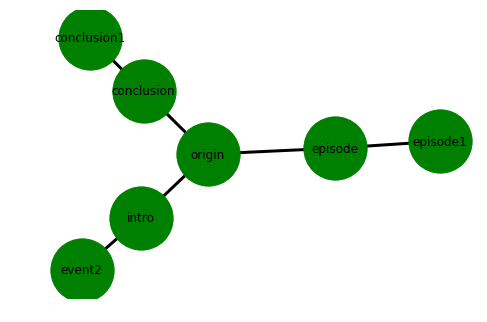

In [8]:
DEBUG = True
rules_us = {
      "origin": [("#intro# #episode# #conclusion#", 1)],
      "loop" : [("#origin#", 0.9 ), ("loop ends.", 0.1)],
      "intro" : [("#event1#", 0.3), ("#event2#", 0.6), ("Good morning!", 0.1)],
      "event1" :[("Sun set in the north.", 1)],
      "event2" :[("Grass is purple.", 1)],
      "episode" : [("#episode1#", 0.5), ("#episode2#", 0.5)],
      "episode1" : [("Earth imploded to form a blackhole.", 1)],
      "episode2" : [("America got government healthcare.", 1)],
      "conclusion" : [("#conclusion1#", 0.7), ("#conclusion2#", 0.3)],
      "conclusion1" : [("World ended.", 1)],
      "conclusion2" : [("God declared world peace.", 1)]
}
parse_tree = nx.Graph()
print(parse_pcfg(rules_us, parse_tree))
options = {
      'node_color': 'green',
      'node_size': 4000,
      'width': 3
}
if DEBUG:
    nx.draw(parse_tree,with_labels=True, **options)